# Classifying Blood Smears with a Convolutional Neural Network


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch03_CNN/ec03_A_blood_smears/blood_smears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [375]:
# !pip install deeplay  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that loads the malaria dataset, trains a convolutional neural network with dense top to classify the images of cells with and without malaria, analyzes where the trained network fails, and shows the network activations and heatmaps.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 3-A from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Malaria Dataset

This dataset was originally published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

It is available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.


In [2]:
import os
from torchvision.datasets.utils import _extract_zip, download_url

dataset_path = os.path.join(".", "mnist_dataset")
if not os.path.exists(dataset_path):
    url = "https://github.com/DeepTrackAI/MNIST_dataset/raw/main/mnist.zip"
    download_url(url, ".")
    _extract_zip("mnist.zip", dataset_path, None)
    os.remove("mnist.zip")

### Transforming the Images and Their Ground Thruth

Define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [3]:
from torchvision.transforms import Compose, Resize, ToTensor

image_trans = Compose([Resize((28, 28)), ToTensor()])

... define a transformation to make the target label equal to 0 for the uninfected cells and to 1 for the parasitized ones, converting it into a floating-point PyTorch tensor and adding a new dimension for batch processing ...

... and define a dataset that also makes these transformations.

In [378]:
from torchvision.datasets import ImageFolder

train_dir = os.path.join(dataset_path, "mnist","train_data")
test_dir = os.path.join(dataset_path,"mnist" ,"test_data")


train_dataset = ImageFolder(train_dir, transform=image_trans)
print(f"Train dataset loaded successfully with {len(train_dataset)} samples.")

test_dataset = ImageFolder(test_dir, transform=image_trans)
print(f"Test dataset loaded successfully with {len(test_dataset)} samples.")
print(train_dataset[0][0].shape)

Train dataset loaded successfully with 60000 samples.
Test dataset loaded successfully with 10000 samples.
torch.Size([3, 28, 28])


In [379]:
train_path = os.path.join("mnist_dataset", "mnist", "train_data", "train")
train_image_files = sorted(os.listdir(train_path))
train_digits = [int(os.path.basename(file)[0]) for file in train_image_files]

new_train_dataset = []
for i in range(len(train_dataset)):
    image, _ = train_dataset[i]
    new_label = train_digits[i]
    new_train_dataset.append((image, new_label))



In [380]:
test_path = os.path.join("mnist_dataset", "mnist", "test_data", "test")
test_image_files = sorted(os.listdir(test_path))
test_digits = [int(os.path.basename(file)[0]) for file in test_image_files]

new_test_dataset = []
for i in range(len(test_dataset)):
    image, _ = test_dataset[i]
    new_label = test_digits[i]
    new_test_dataset.append((image, new_label))


### Visualizing the Blood Smears

Implement a function to plot some examples of blood smears ...

In [381]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_digit_number(dataset):
    """Plot blood smears."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
        ax.imshow(image)
        ax.set_title(f"Digit ({label})", fontsize=16)
    plt.tight_layout()
    plt.show()

... and use it to plot them.

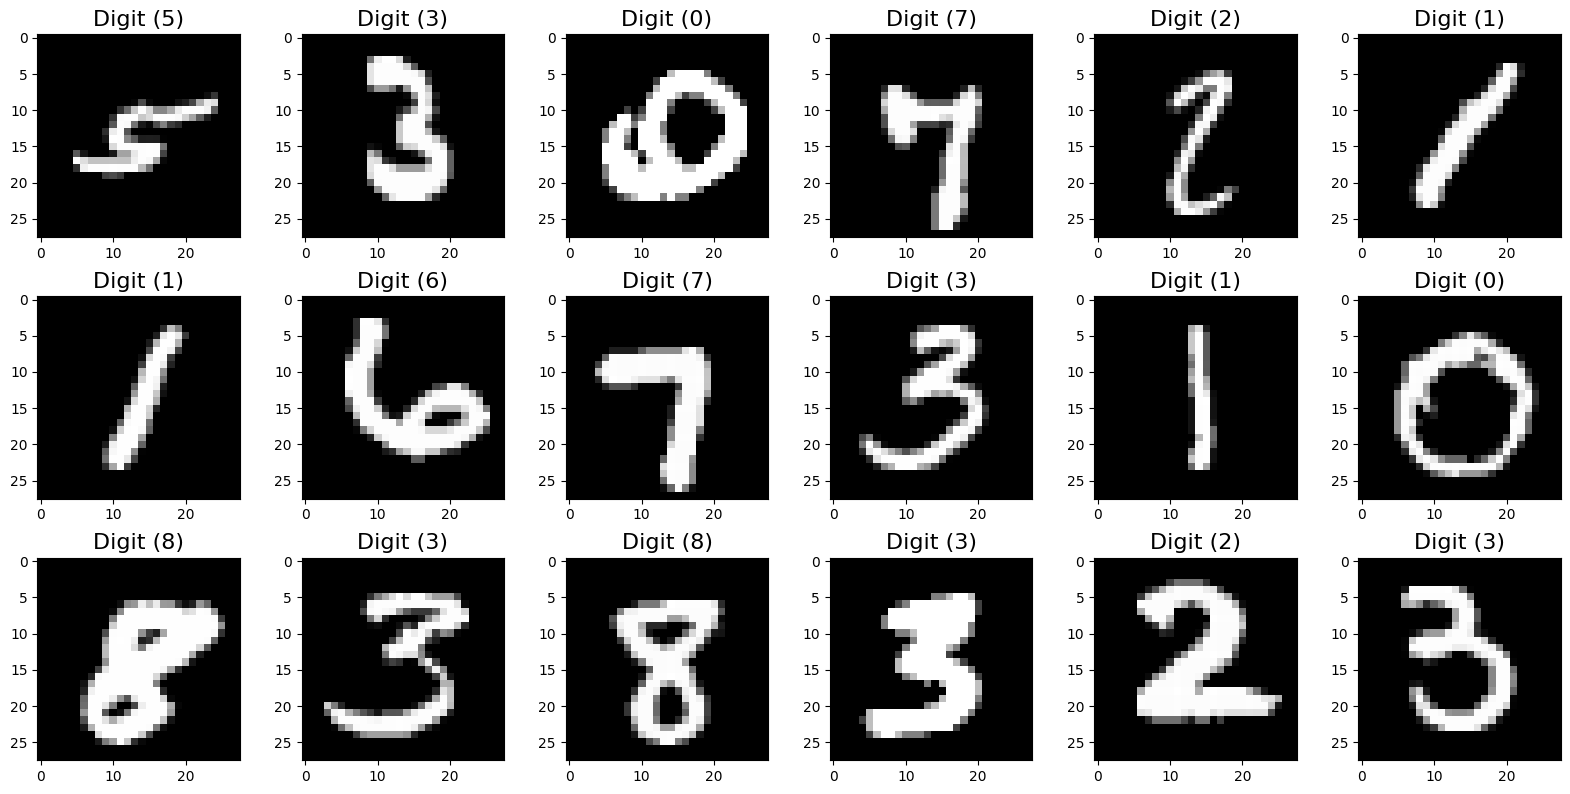

torch.Size([3, 28, 28])


In [382]:
plot_digit_number(new_test_dataset)
print(new_train_dataset[0][0].shape)

### Splitting the Dataset and Defining the Data Loaders

Split the dataset, composed by ca. 27,000 cell images, into train (80%) and test (20%) sets ...

In [383]:
train=new_train_dataset
test=new_test_dataset

... and define the data loaders.

In [384]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
for images, labels in train_loader:
    print(images.shape)
    break
test_loader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=False)

torch.Size([32, 3, 28, 28])


## Classifying the Blood Smears with Dense Neural Networks

Implement a dense neural network ...

In [385]:
import deeplay as dl

dnn = dl.MultiLayerPerceptron(
    in_features=28 * 28*3, hidden_features=[128, 128], out_features=10,
    out_activation=torch.nn.Sigmoid,
)

... print out its detailed architecture ...

In [386]:
print(dnn)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Layer[Linear](in_features=2352, out_features=128, bias=True)
      (activation): Layer[ReLU]()
    )
    (1): LinearBlock(
      (layer): Layer[Linear](in_features=128, out_features=128, bias=True)
      (activation): Layer[ReLU]()
    )
    (2): LinearBlock(
      (layer): Layer[Linear](in_features=128, out_features=10, bias=True)
      (activation): Layer[Sigmoid]()
    )
  )
)


In [387]:
import torch.nn.functional as F

class CategoricalCrossEntropy:
    def __call__(self, predictions, targets):
        log_probs = F.log_softmax(predictions, dim=1)
        loss = -torch.sum(targets * log_probs, dim=1)
        return loss.mean()


... compile it ...

In [388]:
classifier_template = dl.CategoricalClassifier(
    model=dnn,
    num_classes=10,
    make_targets_one_hot=True,
    loss=CategoricalCrossEntropy(),
    optimizer=dl.RMSprop(lr=0.001),
)

classifier = classifier_template.create()




... and print out the compiled dense neural network.

In [389]:
print(classifier)

CategoricalClassifier(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): ReLU()
      )
      (1): LinearBlock(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
      )
      (2): LinearBlock(
        (layer): Linear(in_features=128, out_features=10, bias=True)
        (activation): Sigmoid()
      )
    )
  )
  (optimizer): RMSprop[RMSprop](lr=0.001)
)


The default loss of `dl.BinaryClassifier` is a binary cross-entropy loss.

### Training the Dense Neural Network

In [390]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(classifier, train_loader)

D:\SWEDEN\大三下\TIF360\.venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | train_metrics | MetricCollection     | 0      | train
1 | val_metrics   | MetricCollection     | 0      | train
2 | test_metrics  | MetricCollection     | 0      | train
3 | model         | MultiLayerPerceptron | 318 K  | train
4 | optimizer     | RMSprop              | 0      | train
---------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
D:\SWEDEN\大三下\TIF360\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many 

Epoch 4: 100%|██████████| 1875/1875 [00:11<00:00, 162.18it/s, v_num=15, train_loss_step=1.460, trainMulticlassAccuracy_step=1.000, train_loss_epoch=1.480, trainMulticlassAccuracy_epoch=0.977]


### Testing the Dense Neural Network

In [391]:
dnn_trainer.test(classifier, test_loader)

D:\SWEDEN\大三下\TIF360\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 126.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.972100019454956       │
│       test_loss_epoch        │      1.4849095344543457      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 1.4849095344543457,
  'testMulticlassAccuracy_epoch': 0.972100019454956}]

### Plotting the ROC Curve

Implement a function to plot the ROC curve ...

In [392]:
import torchmetrics as tm

def plot_roc(classifier, loader):
    """Plot ROC curve."""
    roc = tm.ROC(task="multiclass",num_classes=10)
    for image, label in loader:
        roc.update(classifier(image), label.long())

    fig, ax = roc.plot(score=True)
    ax.grid(False)
    ax.axis("square")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right")
    plt.show()

... and use it to plot the performance of the classifier based on a dense neural network.

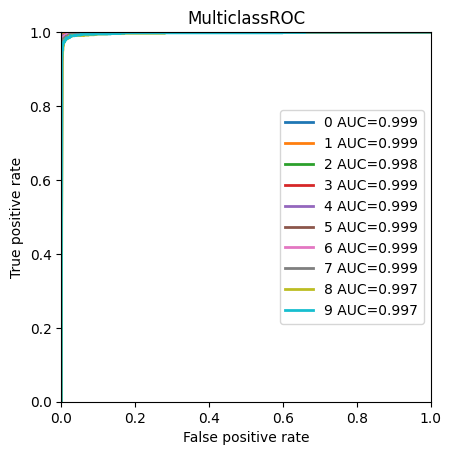

In [393]:
plot_roc(classifier, test_loader)

## Classifying the Blood Smears with Convolutional Neural Networks

Implement a convolutional neural network with a dense top ...

In [395]:
conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=3, hidden_channels=[16, 16, 32], out_channels=32,
)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32, hidden_features=[], out_features=10,
    out_activation=torch.nn.Sigmoid,
)

cnn = dl.Sequential(conv_base, connector, dense_top)

... print out its detailed architecture ...

In [396]:
print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (3): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
  )
  (1): Layer[AdaptiveAvgPool2d](output_size=1)
  (2): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=10, bias=T

... compile it ...

In [397]:
cnn_classifier_template = dl.CategoricalClassifier(
    model=cnn,
    num_classes=10,
    make_targets_one_hot=True,
    loss=CategoricalCrossEntropy(),
    optimizer=dl.RMSprop(lr=0.001),
)

cnn_classifier = cnn_classifier_template.create()

... and print out the compiled convolutional neural network.

In [398]:
print(cnn_classifier)

CategoricalClassifier(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Conv2dBlock(
    

In [399]:
for test in train_loader:
    print(test)
    break


[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

### Training the Convolutional Neural Network

In [400]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

D:\SWEDEN\大三下\TIF360\.venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | test_metrics  | MetricCollection | 0      | train
3 | model         | Sequential       | 17.0 K | train
4 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode
D:\SWEDEN\大三下\TIF360\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottlenec

Epoch 4: 100%|██████████| 1875/1875 [00:29<00:00, 63.09it/s, v_num=16, train_loss_step=1.480, trainMulticlassAccuracy_step=1.000, train_loss_epoch=1.520, trainMulticlassAccuracy_epoch=0.946]


### Testing the Convolutional Neural Network

In [401]:
cnn_trainer.test(cnn_classifier, test_loader)

D:\SWEDEN\大三下\TIF360\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 54.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.963699996471405       │
│       test_loss_epoch        │      1.5070427656173706      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 1.5070427656173706,
  'testMulticlassAccuracy_epoch': 0.963699996471405}]

### Plotting the ROC Curve

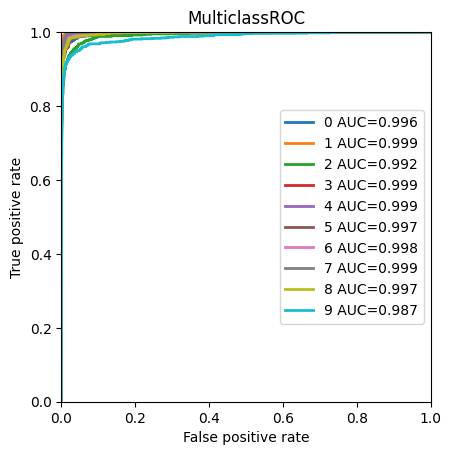

In [402]:
plot_roc(cnn_classifier, test_loader)

### Checking the Values of the Filters

The following code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[15]`). 

In [403]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[15]

print(filter)

tensor([[[ 0.1684,  0.2181,  0.1735],
         [ 0.2565, -0.0601,  0.0775],
         [-0.0130, -0.6248,  0.0182]],

        [[-0.0530,  0.1509,  0.4018],
         [-0.0595,  0.1134,  0.2237],
         [-0.3580, -0.4334, -0.2526]],

        [[ 0.1587,  0.3146,  0.4006],
         [ 0.0553, -0.0174,  0.2415],
         [-0.3890, -0.5562, -0.3133]]], grad_fn=<SelectBackward0>)


### Visualizing the Activations of the Convolutional Layers

Pick the image of an infected smear to then check the activations it produces on the last convolutional layer ...

In [404]:
from PIL import Image

image_filenames = []
image_hrs = []
images = []

found_classes = {i: False for i in range(10)}

for im_ind in range(len(train_dataset.samples)):
    image_filename = train_dataset.samples[im_ind][0]
    file_name = image_filename.split('\\')[-1]
    label = int(file_name[0])

    if not found_classes[label]:
        image_hr = Image.open(image_filename).convert('RGB')
        image = image_trans(image_hr)

        image_filenames.append(image_filename)
        image_hrs.append(image_hr)
        images.append(image)

        found_classes[label] = True

    if all(found_classes.values()):
        break

print(len(images))


10


... verify whether this image is of a parasitized cell ...

In [405]:
print(train_dataset.targets[im_ind])

0


... define a function to visualize the activations ...

In [406]:
def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)
    plt.show()

... add a hook to access the activations in the forward pass ...


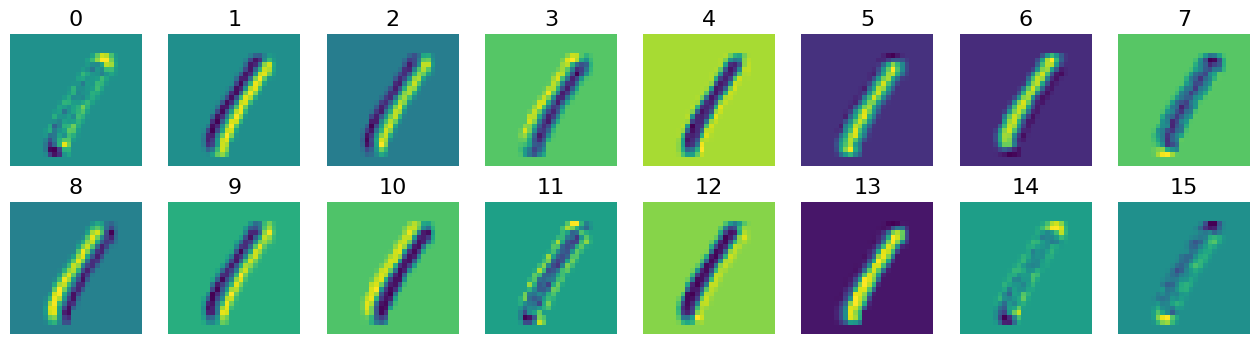

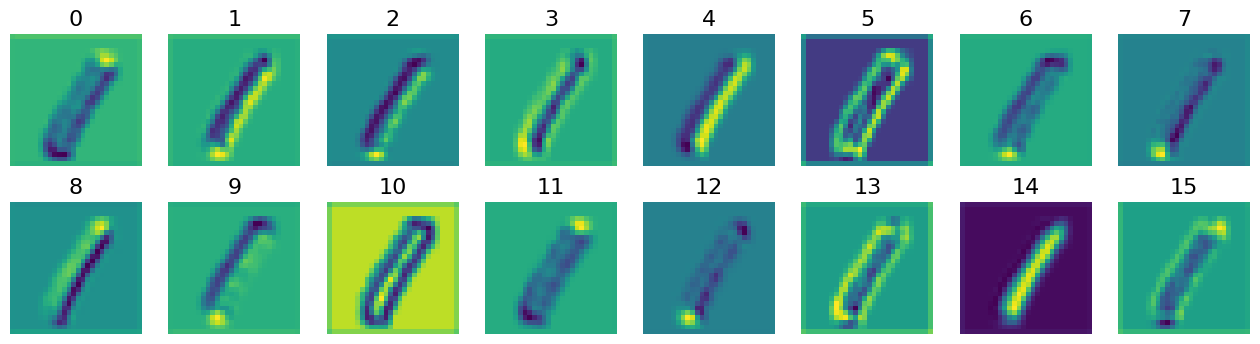

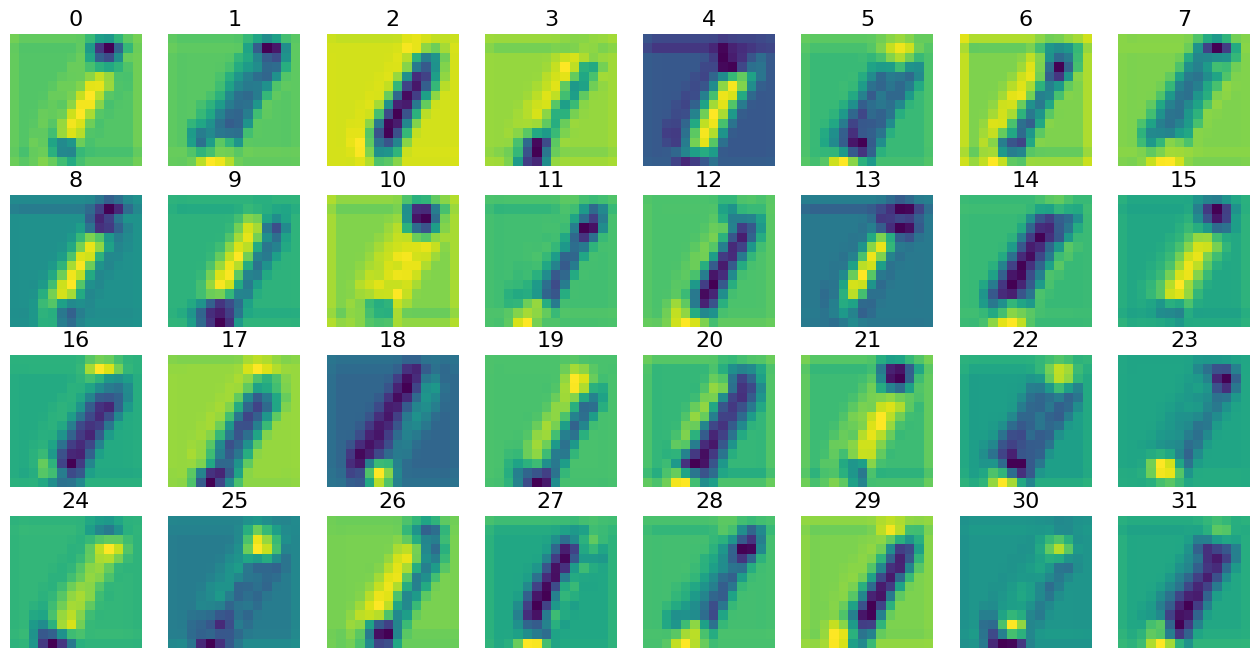

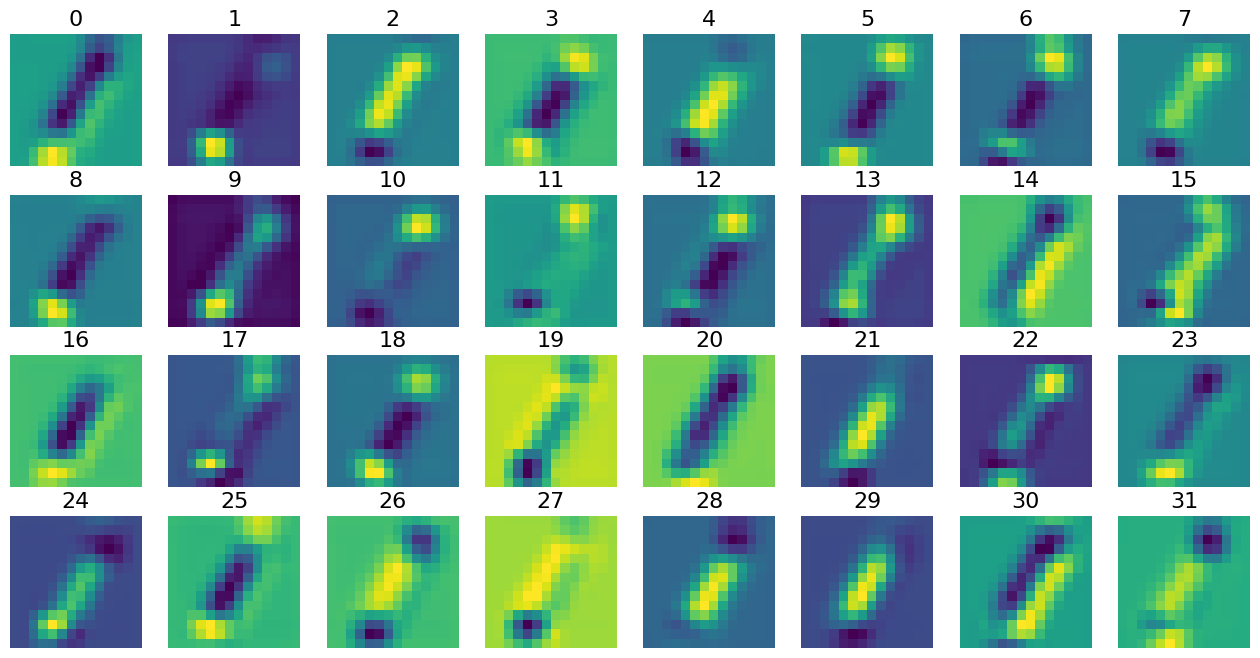

In [407]:
def hook_func(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_classifier.model[0].blocks:
    layer = block.layer
    handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_classifier.model(images[1].unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

### Visualizing the Heatmaps

Use hooks to keep tracks also of the gradients in the backward pass ...

In [408]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    """Forward hook function."""
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    """Backward hook function."""
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

try:
    pred = cnn_classifier.model(images[1].unsqueeze(0))
    pred.sum().backward()
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
finally:
    handle_fwd_hook.remove()
    handle_bwd_hook.remove()

... calculate the heatmap combining activations and gradients ...

In [409]:
from torch.nn.functional import relu

activations = hookdata["activations"][0]
gradients = hookdata["gradients"][0]

pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
heatmap = relu((pooled_gradients * activations).sum(0)).detach().numpy()

... and plot the heatmap.

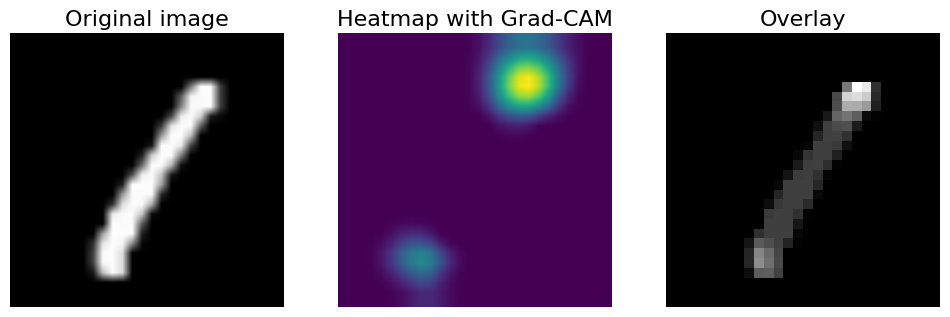

In [410]:
from numpy import array
from skimage.exposure import rescale_intensity
from skimage.transform import resize

rescaled_image = rescale_intensity(array(image_hrs[1]), out_range=(0, 1))
resized_heatmap = resize(heatmap, rescaled_image.shape, order=2)
rescaled_heatmap = rescale_intensity(resized_heatmap, out_range=(0.25, 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(rescaled_image, interpolation="bilinear")
plt.title("Original image", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rescaled_heatmap.mean(axis=-1), interpolation="bilinear")
plt.title("Heatmap with Grad-CAM", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(rescaled_image * rescaled_heatmap)
plt.title("Overlay", fontsize=16)
plt.axis("off")

plt.show()

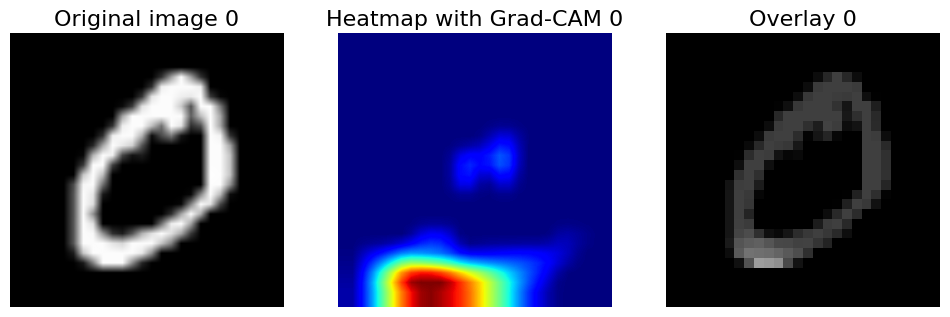

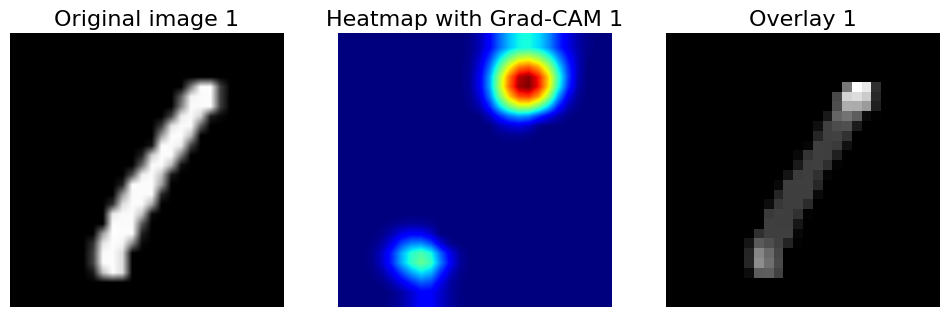

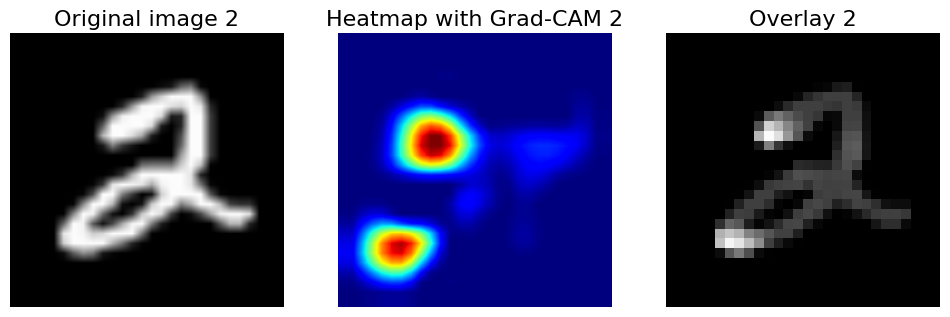

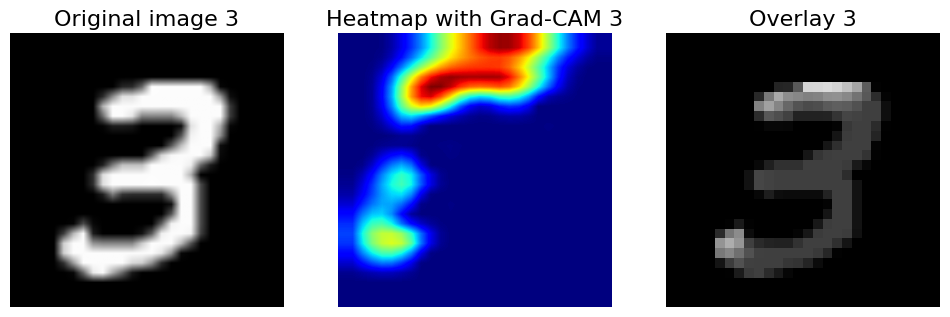

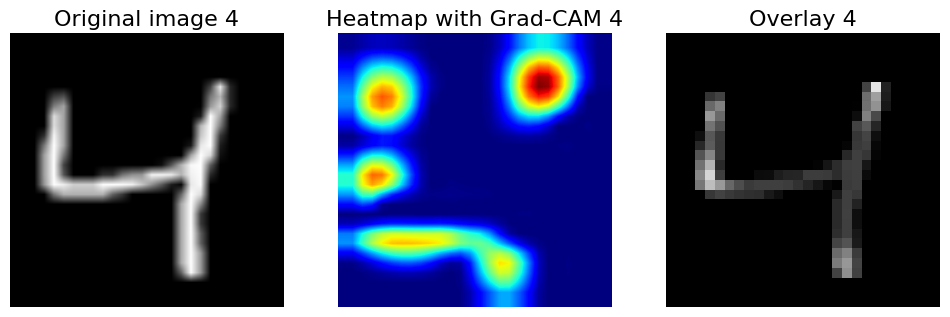

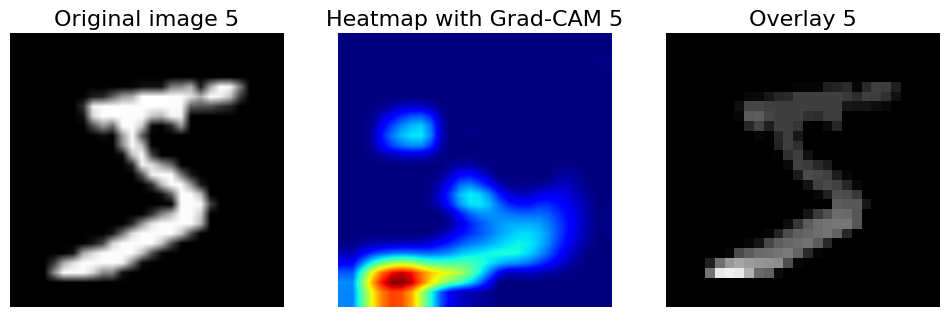

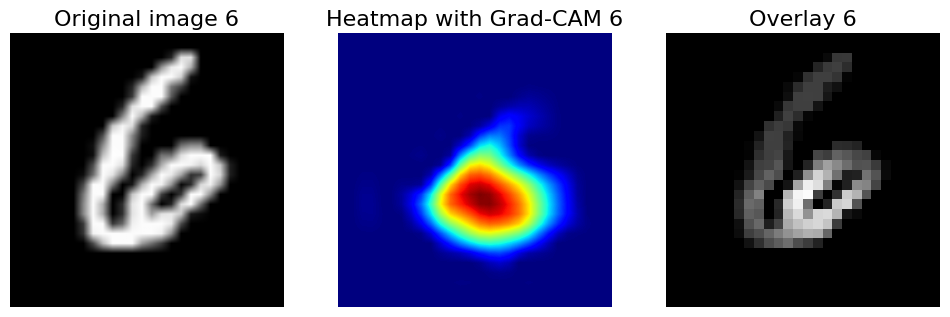

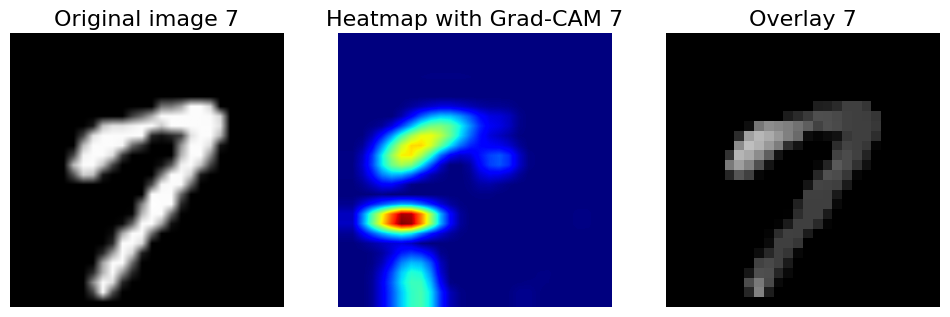

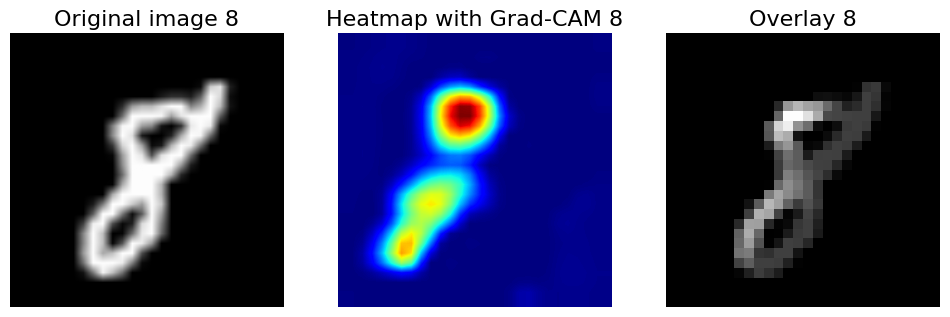

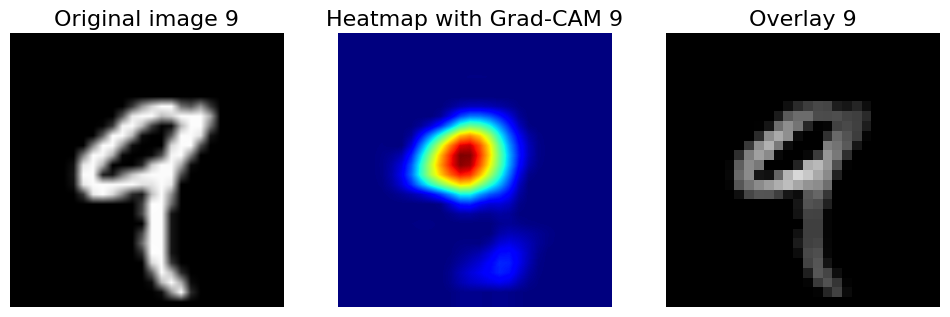

In [411]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

from torch.nn.functional import relu
from numpy import array
from skimage.exposure import rescale_intensity
from skimage.transform import resize
import matplotlib.pyplot as plt

for i in range(10):
    try:
        image = images[i]
        image_hr = image_hrs[i]

        pred = cnn_classifier.model(image.unsqueeze(0))
        cnn_classifier.model.zero_grad()
        pred.sum().backward()

        activations = hookdata["activations"][0]
        gradients = hookdata["gradients"][0]

        pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
        weighted_activations = pooled_gradients * activations
        heatmap = weighted_activations.sum(dim=0)
        heatmap = relu(heatmap).detach().numpy()

        rescaled_image = rescale_intensity(array(image_hr), out_range=(0, 1))
        resized_heatmap = resize(heatmap, rescaled_image.shape[:2], order=2)
        rescaled_heatmap = rescale_intensity(resized_heatmap, out_range=(0.25, 1))

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(rescaled_image, interpolation="bilinear")
        plt.title(f"Original image {i}", fontsize=16)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(rescaled_heatmap, interpolation="bilinear", cmap="jet")
        plt.title(f"Heatmap with Grad-CAM {i}", fontsize=16)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(rescaled_image * rescaled_heatmap[..., None])
        plt.title(f"Overlay {i}", fontsize=16)
        plt.axis("off")

        plt.show()

    except Exception as e:
        print(f"An error occurred during model prediction for image {i}: {e}")
        continue

handle_fwd_hook.remove()
handle_bwd_hook.remove()
